# LeNet-5 手写数字识别 (PyTorch + TensorBoardX)

此笔记展示使用经典 LeNet-5 结构在 MNIST 数据集上的训练示例。使用 `tensorboardX` 记录训练指标并演示如何可视化。仅使用 PyTorch、torchvision、numpy 与 matplotlib。

In [2]:
# Imports
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter


## 计算公式与关键参数速览（LeNet-5 相关）

> 面向初学者：下面给出卷积/池化/全连接层的常用计算公式与关键参数解释，便于理解后续网络结构。

- 卷积输出尺寸（单维度，高或宽相同计算）
  - 公式：$H_{out} = \left\lfloor \frac{H_{in} + 2P - D\cdot(K-1) - 1}{S} + 1 \right\rfloor$
  - 符号：$K$=kernel_size，$S$=stride，$P$=padding，$D$=dilation。
- 池化输出尺寸（平均/最大池化同理）
  - 公式：$H_{out} = \left\lfloor \frac{H_{in} + 2P - (K-1) - 1}{S} + 1 \right\rfloor$
- Conv2d 关键参数（PyTorch）
  - `in_channels`：输入通道数（灰度图为1，RGB为3）
  - `out_channels`：卷积核个数（输出通道数）
  - `kernel_size`：卷积核大小（如 5 或 (5,5)）
  - `stride`：步幅，默认1
  - `padding`：边缘补零，默认0
  - `dilation`：空洞率，默认1
  - `groups`：分组卷积，默认1（常用全通）
  - `bias`：是否带偏置，默认True
  - `padding_mode`：'zeros'（默认）、'reflect' 等
- AvgPool2d 关键参数
  - `kernel_size`、`stride`、`padding`：与卷积同名参数含义一致（一般 stride=kernel_size）
  - `ceil_mode`：是否向上取整输出尺寸，默认False
  - `count_include_pad`：计算平均时是否计入 padding 的0，默认False
- Linear（全连接）关键参数
  - `in_features`：输入特征维度
  - `out_features`：输出特征维度
  - `bias`：是否带偏置
- 参数量（Parameter Count）估算
  - Conv2d：$\text{params} = C_{out} \times \left(\frac{C_{in}}{\text{groups}} \times K_h \times K_w\right) + (\text{bias? } C_{out}:0)$
  - Linear：$\text{params} = \text{in\_features} \times \text{out\_features} + (\text{bias? } \text{out\_features}:0)$
- 激活函数 Tanh
  - 公式：$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$，输出范围(-1,1)
- 交叉熵损失 CrossEntropyLoss（训练单元使用）
  - 期望输入未归一化`logits`（shape: [N, C]），标签为类别索引`LongTensor`（shape: [N]）
  - 内部等价于 LogSoftmax + NLLLoss
- 本网络（输入32×32，因前置Pad(2)）各层输出尺寸速查
  - 输入：1×32×32（灰度）
  - Conv(5×5, stride=1, pad=0) → 6×28×28
  - AvgPool(2×2, stride=2) → 6×14×14
  - Conv(5×5, stride=1, pad=0) → 16×10×10
  - AvgPool(2×2, stride=2) → 16×5×5
  - Conv(5×5, stride=1, pad=0) → 120×1×1
  - Flatten → 120 → Linear(120→84) → Linear(84→10)


In [3]:
# 定义 LeNet-5（基于经典结构的 PyTorch 实现）
# 说明：
# - LeNet-5 是早期的经典卷积网络结构，适合 MNIST 这类小型手写数字识别任务。
# - 本实现严格显式填写每个层的所有关键参数，帮助你理解每个参数的作用。
# - 输入尺寸采用 32×32：我们在数据预处理里对 28×28 的 MNIST 图像进行了 Pad(2)，方便复现原论文的维度。
# - 张量形状约定为 NCHW：N=批大小，C=通道，H=高度，W=宽度。
#
# 其中 K=kernel_size, S=stride, P=padding, D=dilation。

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()

        # 特征提取部分（卷积 + 激活 + 池化）
        # 输入假设为 1×32×32（灰度图像 + 预处理Pad(2)）
        self.features = nn.Sequential(
            # 第1个卷积层：1->6 通道，5×5 卷积核，步幅1，无填充
            # 形状变化：1×32×32 -> 6×28×28，因为 (32 - 5 + 2*0)/1 + 1 = 28
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,
                      stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'),
            # 非线性激活：Tanh，输出范围(-1,1)
            nn.Tanh(),
            # 平均池化：2×2，步幅2，无填充
            # 形状变化：6×28×28 -> 6×14×14
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0,
                         ceil_mode=False, count_include_pad=False),

            # 第2个卷积层：6->16 通道，5×5 卷积核，步幅1
            # 形状变化：6×14×14 -> 16×10×10，因为 (14 - 5)/1 + 1 = 10
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,
                      stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'),
            nn.Tanh(),
            # 平均池化：2×2，步幅2
            # 形状变化：16×10×10 -> 16×5×5
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0,
                         ceil_mode=False, count_include_pad=False),

            # 第3个卷积层：16->120 通道，5×5 卷积核，步幅1
            # 形状变化：16×5×5 -> 120×1×1，因为 (5 - 5)/1 + 1 = 1
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5,
                      stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'),
            nn.Tanh()
        )

        # 分类器部分（全连接层）
        # 上一层输出是 120×1×1，即每个样本 120 维特征，因此 in_features=120
        self.classifier = nn.Sequential(
            # 120 -> 84 的全连接层
            # 参数量 = 120*84 + 84(偏置) = 10,164
            nn.Linear(in_features=120, out_features=84, bias=True),
            nn.Tanh(),
            # 84 -> num_classes(10) 的输出层（未加Softmax；训练用 CrossEntropyLoss 会内部处理）
            # 参数量 = 84*10 + 10(偏置) = 850
            nn.Linear(in_features=84, out_features=num_classes, bias=True)
        )

    def forward(self, x):
        # x 形状：N×1×32×32
        x = self.features(x)   # 经过卷积/池化后：N×120×1×1
        x = x.view(x.size(0), -1)  # 展平为：N×120（保留批维度N，合并其余维度）
        x = self.classifier(x)  # 全连接分类：N×10（每个类别一个logit）
        return x

# 测试模型构建与结构打印（便于确认各层参数与输出形状）
model = LeNet5()
print(model)


LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [4]:
# 数据准备：MNIST (训练/测试)，使用现有的 ./MNIST 数据并禁用下载；将 28x28 pad 到 32x32 以匹配 LeNet 原始设置
batch_size = 64
transform = transforms.Compose([
    # Pad(2)：在图像四周各加 2 个像素（默认用 0 填充），把 28x28 -> 32x32
    # 必须在 ToTensor 之前：因为 Pad 操作作用于 PIL 图像（像素值为 0..255），
    # 而 ToTensor 会把像素缩放到 0..1 的 float；如果顺序反了，Pad 会作用于张量，行为不同。
    transforms.Pad(2),               # 28 -> 32

    # ToTensor：PIL Image -> Tensor，且把像素值从 [0,255] 映射到 [0.0,1.0]
    # 输出通道顺序为 C×H×W（这里 C=1），数据类型 float32
    transforms.ToTensor(),

    # Normalize：按通道做 (x - mean) / std，常用做法是用训练集的全局 mean/std
    # 对 MNIST 使用常见值 mean=0.1307, std=0.3081（单通道，所以以元组形式传入）
    # 这样做能让输入分布更接近标准正态，有利于优化器稳定与加速收敛
    transforms.Normalize((0.1307,), (0.3081,))
])

# root 指向当前目录 '.'，torchvision 会在 './MNIST' 下查找 raw/processed
train_dataset = datasets.MNIST(root='.', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print('Train samples:', len(train_dataset), 'Test samples:', len(test_dataset))

Train samples: 60000 Test samples: 10000


随机样本索引: 53089
原始标签 (label): 2
原始图像张量形状: (28, 28), dtype: torch.uint8, 像素范围: [0, 255]
原始 28x28 图像 (未 Pad / 未 Normalize)：


变换后张量形状: (1, 32, 32) (C,H,W)，dtype: torch.float32
变换后张量统计: mean=0.0184, std=1.0299, min=-0.4242, max=2.8215
变换后 (Pad + Normalize 反归一化) 32x32 图像：


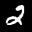

说明: 原始图像为 28x28；经 Pad(2) 后四周补零成为 32x32，再做 ToTensor 与 Normalize。上面第二张为已反归一化后的 32x32。


In [5]:
# 随机抽取并查看一个训练样本：打印张量信息并用 PIL 显示原始与变换后图像
import random
from PIL import Image
from IPython.display import display

# 随机索引
idx = random.randint(0, len(train_dataset) - 1)

# 原始 MNIST 数据（未经过 transforms），来自 train_dataset.data (uint8, 28x28)
raw_img28 = train_dataset.data[idx]          # shape: (28,28), dtype: torch.uint8
raw_label = int(train_dataset.targets[idx])  # 标签

print(f"随机样本索引: {idx}")
print(f"原始标签 (label): {raw_label}")
print(f"原始图像张量形状: {tuple(raw_img28.shape)}, dtype: {raw_img28.dtype}, 像素范围: [{raw_img28.min().item()}, {raw_img28.max().item()}]")

# 使用 PIL 展示原始 28x28 灰度图
pil_raw = Image.fromarray(raw_img28.numpy(), mode='L')
print("原始 28x28 图像 (未 Pad / 未 Normalize)：")
display(pil_raw)

# 经 transforms 后的图像（已经 Pad -> ToTensor -> Normalize）
trans_img_tensor, trans_label = train_dataset[idx]  # trans_label 应与 raw_label 相同
assert trans_label == raw_label

print(f"变换后张量形状: {tuple(trans_img_tensor.shape)} (C,H,W)，dtype: {trans_img_tensor.dtype}")
print(f"变换后张量统计: mean={trans_img_tensor.mean().item():.4f}, std={trans_img_tensor.std().item():.4f}, min={trans_img_tensor.min().item():.4f}, max={trans_img_tensor.max().item():.4f}")

# 反归一化用于可视化：x = x*std + mean
_MEAN, _STD = 0.1307, 0.3081
unnorm = trans_img_tensor * _STD + _MEAN  # 回到 [0,1] 近似分布（仍然是 32x32）
arr32 = unnorm.squeeze().numpy()          # shape: (32,32)
arr32_disp = (arr32 * 255.0).clip(0, 255).astype('uint8')
pil_trans = Image.fromarray(arr32_disp, mode='L')
print("变换后 (Pad + Normalize 反归一化) 32x32 图像：")
display(pil_trans)

# 对比说明
print("说明: 原始图像为 28x28；经 Pad(2) 后四周补零成为 32x32，再做 ToTensor 与 Normalize。上面第二张为已反归一化后的 32x32。")

In [6]:
# 训练与验证函数（增强 TensorBoard 可视化）
import itertools

def log_sample_images(writer, images, global_step, tag_prefix="train"):
    # 仅取前 8 张
    grid = make_grid(images[:8], nrow=4, normalize=True, scale_each=True)
    writer.add_image(f"{tag_prefix}/samples", grid, global_step)


def train(model, device, train_loader, optimizer, criterion, epoch, writer, log_interval=100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        global_step = epoch * len(train_loader) + batch_idx
        # 记录学习率与 batch loss（更细粒度）
        writer.add_scalar('metrics/train/batch_loss', loss.item(), global_step)
        writer.add_scalar('metrics/train/lr', optimizer.param_groups[0]['lr'], global_step)

        # 间隔记录样本图像与卷积核权重直方图
        if batch_idx == 0:
            log_sample_images(writer, data, global_step, tag_prefix="images/train")
        if (batch_idx + 1) % (log_interval * 2) == 0:
            writer.add_histogram('weights/conv1', model.features[0].weight.detach().cpu(), global_step)

        if (batch_idx + 1) % log_interval == 0:
            avg_loss = running_loss / log_interval
            acc = 100. * correct / total
            writer.add_scalar('metrics/train/avg_loss', avg_loss, global_step)
            writer.add_scalar('metrics/train/avg_accuracy', acc, global_step)
            print(f'Epoch: {epoch} [{batch_idx+1}/{len(train_loader)}]  Loss: {avg_loss:.4f}  Acc: {acc:.2f}%')
            running_loss = 0.0
            correct = 0
            total = 0


def _confusion_matrix(num_classes, preds, targets):
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for p, t in zip(preds, targets):
        cm[t, p] += 1
    return cm


def _plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = cm[i, j].item()
        if val > 0:
            ax.text(j, i, val, ha='center', va='center', color='black', fontsize=8)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def test(model, device, test_loader, criterion, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    mis_images = []
    mis_pairs = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss_batch = criterion(output, target).item()
            test_loss += loss_batch * data.size(0)
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            all_preds.append(predicted.cpu())
            all_targets.append(target.cpu())
            # 收集前若干误分类样本
            mismask = predicted.ne(target)
            if mismask.any() and len(mis_images) < 16:
                idxs = torch.where(mismask)[0]
                for idx in idxs:
                    if len(mis_images) >= 16:
                        break
                    mis_images.append(data[idx].cpu())
                    mis_pairs.append((int(target[idx].item()), int(predicted[idx].item())))
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')
    writer.add_scalar('metrics/test/loss', test_loss, epoch)
    writer.add_scalar('metrics/test/accuracy', acc, epoch)

    # 记录误分类样本图像
    if mis_images:
        mis_stack = torch.stack(mis_images)
        grid = make_grid(mis_stack, nrow=4, normalize=True, scale_each=True)
        writer.add_image('images/test/misclassified', grid, epoch)

    # 混淆矩阵
    preds_cat = torch.cat(all_preds)
    targets_cat = torch.cat(all_targets)
    cm = _confusion_matrix(10, preds_cat, targets_cat)
    fig_cm = _plot_confusion_matrix(cm, [str(i) for i in range(10)])
    writer.add_figure('metrics/test/confusion_matrix', fig_cm, epoch)
    plt.close(fig_cm)

    return test_loss, acc


In [ ]:
# 自动启动 TensorBoard 并打开浏览器（在训练前执行）
import os, time, sys, subprocess, webbrowser

# 与训练日志目录保持一致
tb_logdir = './runs/lenet_mnist'
os.makedirs(tb_logdir, exist_ok=True)


def _start_tensorboard(logdir: str, preferred_port: int = 6006) -> str:
    """优先通过 TensorBoard API 启动；失败则尝试子进程启动。返回访问 URL。"""
    try:
        from tensorboard import program  # 需要安装 `tensorboard`
        tb = program.TensorBoard()
        tb.configure(argv=[None, '--logdir', logdir, '--port', str(preferred_port), '--host', '127.0.0.1'])
        url = tb.launch()
        return url
    except Exception:
        # 退回到子进程方式：python -m tensorboard ...
        try:
            subprocess.Popen(
                [sys.executable, '-m', 'tensorboard', f'--logdir={logdir}', f'--port={preferred_port}', '--host=127.0.0.1'],
                stdout=subprocess.DEVNULL,
                stderr=subprocess.STDOUT,
            )
            return f'http://127.0.0.1:{preferred_port}'
        except Exception as e2:
            print('无法启动 TensorBoard，请先安装: pip install tensorboard')
            raise e2


def start_tensorboard_with_fallbacks(logdir: str, base_port: int = 6006, tries: int = 3) -> str:
    for k in range(tries):
        port = base_port + k
        try:
            url = _start_tensorboard(logdir, preferred_port=port)
            return url
        except Exception:
            continue
    # 最后返回默认 URL（不保证可用，仅用于提示）
    return f'http://127.0.0.1:{base_port}'


# 启动并打开浏览器
_tb_url = start_tensorboard_with_fallbacks(tb_logdir, base_port=6006, tries=3)
print('TensorBoard URL:', _tb_url)
# 稍等片刻，确保服务已就绪
time.sleep(2)
try:
    webbrowser.open(_tb_url)
except Exception:
    print('请在浏览器中手动打开:', _tb_url)

TensorBoard URL: http://127.0.0.1:6006/


In [8]:
# 主运行：模型、优化器和训练循环
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# TensorBoardX writer（写入 runs/lenet_mnist）
logdir = './runs/lenet_mnist'
os.makedirs(logdir, exist_ok=True)
writer = SummaryWriter(logdir)

start_epoch = 1
epochs = 5  # 可以根据需要调整
for epoch in range(start_epoch, start_epoch + epochs):
    t0 = time.time()
    train(model, device, train_loader, optimizer, criterion, epoch, writer)
    test(model, device, test_loader, criterion, epoch, writer)
    print(f'Epoch {epoch} finished in {time.time() - t0:.1f}s')

# 保存模型
model_path = './lenet_mnist.pth'
torch.save(model.state_dict(), model_path)
print('Model saved to', model_path)
writer.close()

Epoch: 1 [100/938]  Loss: 1.5812  Acc: 58.28%
Epoch: 1 [200/938]  Loss: 0.4602  Acc: 87.55%
Epoch: 1 [200/938]  Loss: 0.4602  Acc: 87.55%
Epoch: 1 [300/938]  Loss: 0.3239  Acc: 90.64%
Epoch: 1 [300/938]  Loss: 0.3239  Acc: 90.64%
Epoch: 1 [400/938]  Loss: 0.2804  Acc: 91.34%
Epoch: 1 [400/938]  Loss: 0.2804  Acc: 91.34%
Epoch: 1 [500/938]  Loss: 0.2416  Acc: 92.77%
Epoch: 1 [500/938]  Loss: 0.2416  Acc: 92.77%
Epoch: 1 [600/938]  Loss: 0.2069  Acc: 93.95%
Epoch: 1 [600/938]  Loss: 0.2069  Acc: 93.95%
Epoch: 1 [700/938]  Loss: 0.1772  Acc: 94.66%
Epoch: 1 [700/938]  Loss: 0.1772  Acc: 94.66%
Epoch: 1 [800/938]  Loss: 0.1581  Acc: 95.17%
Epoch: 1 [800/938]  Loss: 0.1581  Acc: 95.17%
Epoch: 1 [900/938]  Loss: 0.1387  Acc: 95.92%
Epoch: 1 [900/938]  Loss: 0.1387  Acc: 95.92%

Test set: Average loss: 0.1162, Accuracy: 9635/10000 (96.35%)


Test set: Average loss: 0.1162, Accuracy: 9635/10000 (96.35%)

Epoch 1 finished in 13.8s
Epoch 1 finished in 13.8s
Epoch: 2 [100/938]  Loss: 0.1217  Acc:

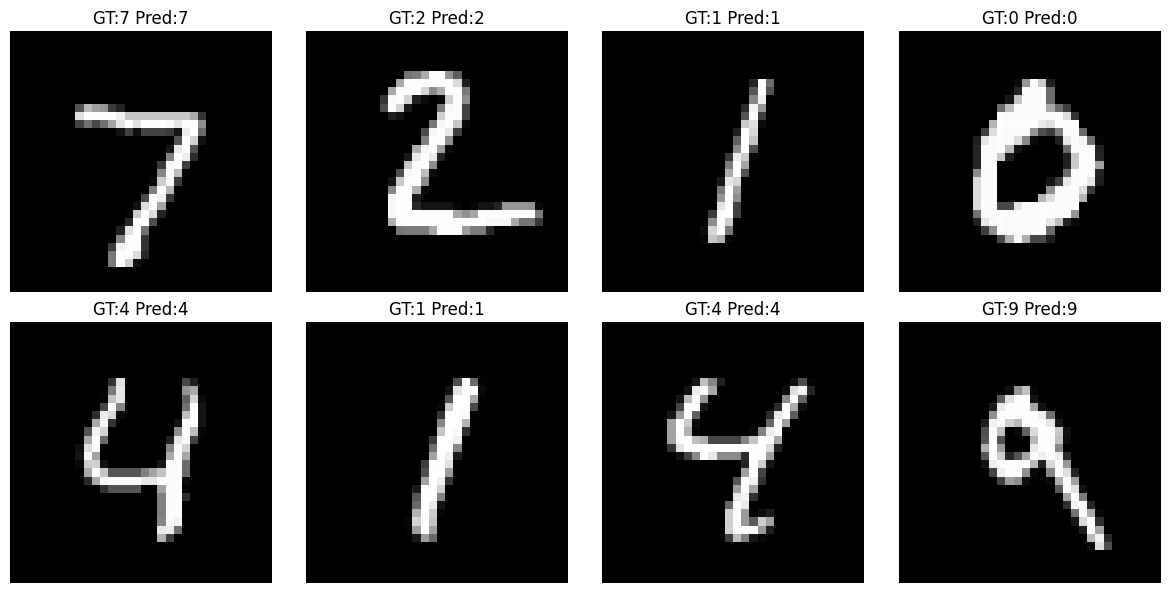

In [9]:
# 示例：加载保存的模型并可视化若干预测结果
# 加载模型
model = LeNet5()
model.load_state_dict(torch.load('./lenet_mnist.pth', map_location='cpu'))
model.eval()

# 取几张测试图像并预测
examples = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        if i >= 1:
            break
        outputs = model(data)
        preds = outputs.argmax(dim=1).numpy()
        for j in range(min(8, data.size(0))):
            img = data[j].squeeze().numpy()
            examples.append(img)
            labels.append((int(target[j].item()), int(preds[j].item())))

# 绘制
plt.figure(figsize=(12, 6))
for idx, img in enumerate(examples):
    plt.subplot(2, 4, idx+1)
    plt.imshow(img, cmap='gray')
    gt, pr = labels[idx]
    plt.title(f'GT:{gt} Pred:{pr}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 本地手写窗口（Tkinter）

- 运行下一个单元将打开一个本地窗口。
- 操作：按住左键在白板上书写；点击“识别”进行推断；“清空”重置画布；“退出”关闭窗口。
- 说明：此窗口使用 Tkinter（Windows 通常自带）。若环境未安装 Tk 支持，可能无法启动。

In [10]:
# 本地手写窗口：Tkinter 画布 + LeNet-5 推理
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.nn.functional as F

# Tkinter 可能在某些环境不可用
try:
    import tkinter as tk
except Exception as e:
    print("未能导入 Tkinter：", e)
    raise

# 复用已定义的 LeNet5，如果此单元单独运行则做一次定义
try:
    LeNet5
except NameError:
    class LeNet5(nn.Module):
        def __init__(self, num_classes=10):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'),
                nn.Tanh(),
                nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=False),
                nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'),
                nn.Tanh(),
                nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=False),
                nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'),
                nn.Tanh()
            )
            self.classifier = nn.Sequential(
                nn.Linear(in_features=120, out_features=84, bias=True),
                nn.Tanh(),
                nn.Linear(in_features=84, out_features=num_classes, bias=True)
            )
        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x

# 加载模型（CPU 推理）
_device = torch.device('cpu')
_model = LeNet5().to(_device)
weights_path = './lenet_mnist.pth'
if os.path.exists(weights_path):
    _model.load_state_dict(torch.load(weights_path, map_location=_device))
    _model.eval()
else:
    print('警告：未找到模型权重 ./lenet_mnist.pth，请先运行训练单元保存模型。')

_MEAN, _STD = 0.1307, 0.3081


def _preprocess_pil(pil_img: Image.Image) -> torch.Tensor:
    """将 PIL 图像转换为 1×1×32×32 标准化张量（与训练一致）。"""
    if pil_img.mode != 'L':
        pil_img = pil_img.convert('L')
    pil_img = pil_img.resize((28, 28), Image.NEAREST)
    arr = np.array(pil_img).astype(np.float32) / 255.0
    arr = 1.0 - arr  # 画布白底黑字 -> MNIST 黑底白字
    arr = (arr - _MEAN) / _STD
    arr = np.pad(arr, pad_width=((2, 2), (2, 2)), mode='constant', constant_values=0.0)
    ten = torch.from_numpy(arr)[None, None, :, :].to(_device)
    return ten


def _predict_from_pil(pil_img: Image.Image):
    if _model is None:
        return {str(i): 0.0 for i in range(10)}
    x = _preprocess_pil(pil_img)
    with torch.no_grad():
        logits = _model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    return {str(i): float(probs[i]) for i in range(10)}


# === Tkinter 手写窗口 ===
CANVAS_SIZE = 280            # 画布像素大小（放大版）
BRUSH_WIDTH = 12             # 笔刷粗细

root = tk.Tk()
root.title('MNIST 手写数字识别 (LeNet-5) - 本地窗口')

canvas = tk.Canvas(root, width=CANVAS_SIZE, height=CANVAS_SIZE, bg='white')
canvas.pack(padx=8, pady=8)

# 用于推理的灰度图缓存（白底）
buffer_img = Image.new('L', (CANVAS_SIZE, CANVAS_SIZE), color=255)
buffer_draw = ImageDraw.Draw(buffer_img)

last_pos = {'x': None, 'y': None}


def on_button_press(event):
    last_pos['x'], last_pos['y'] = event.x, event.y


def on_move(event):
    lx, ly = last_pos['x'], last_pos['y']
    if lx is None or ly is None:
        last_pos['x'], last_pos['y'] = event.x, event.y
        return
    x, y = event.x, event.y
    canvas.create_line(lx, ly, x, y, width=BRUSH_WIDTH, fill='black', capstyle=tk.ROUND, smooth=True)
    buffer_draw.line([lx, ly, x, y], fill=0, width=BRUSH_WIDTH)
    last_pos['x'], last_pos['y'] = x, y


def on_button_release(event):
    last_pos['x'], last_pos['y'] = None, None


def clear_canvas():
    canvas.delete('all')
    buffer_draw.rectangle([(0, 0), (CANVAS_SIZE, CANVAS_SIZE)], fill=255)
    result_var.set('结果：')


def predict_canvas():
    probs = _predict_from_pil(buffer_img)
    # 取 Top-3 显示
    items = sorted([(int(k), v) for k, v in probs.items()], key=lambda kv: kv[1], reverse=True)[:3]
    text = '结果：' + '  '.join([f'{k}: {v*100:.2f}%' for k, v in items])
    result_var.set(text)


btn_frame = tk.Frame(root)
btn_frame.pack(fill='x', padx=8, pady=4)

tk.Button(btn_frame, text='识别', command=predict_canvas).pack(side='left', padx=4)
tk.Button(btn_frame, text='清空', command=clear_canvas).pack(side='left', padx=4)
tk.Button(btn_frame, text='退出', command=root.destroy).pack(side='right', padx=4)

result_var = tk.StringVar(value='结果：')
result_label = tk.Label(root, textvariable=result_var, anchor='w')
result_label.pack(fill='x', padx=8, pady=4)

canvas.bind('<ButtonPress-1>', on_button_press)
canvas.bind('<B1-Motion>', on_move)
canvas.bind('<ButtonRelease-1>', on_button_release)

# 启动窗口（注意：在某些 Jupyter 环境中主线程阻塞是预期行为）
try:
    root.mainloop()
except Exception as e:
    print('Tkinter 主循环启动失败：', e)
